<a href="https://colab.research.google.com/github/JVR27XD/SAM/blob/main/FastSAM/FastSAM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Este bloque prepara el entorno para evaluar FastSAM en cuatro modalidades de prompting (POINT/BOX/COMBO/MULTI).
Hace tres cosas clave:

Fija dependencias (Ultralytics 8.0.120) y evita errores por integraciones opcionales (ClearML, W&B, etc.) mediante stubs seguros.

Proporciona una carga de checkpoints .pt segura en PyTorch 2.6+ con allowlist para weights_only=True y fallback controlado.

Define el preprocesado (letterbox a 1024, normalización ImageNet, proyección de prompts) y un Dataset que genera, proyecta y sanea prompts desde la GT original para cada modo.

In [ ]:

# Instalar dependencias
!pip -q uninstall -y ultralytics
!pip -q install "ultralytics==8.0.120" gdown shapely pycocotools opencv-python-headless
!pip -q install --no-deps git+https://github.com/CASIA-IVA-Lab/FastSAM.git

# Evita ModuleNotFoundError por integraciones opcionales de Ultralytics
import sys, types, os, importlib.abc, importlib.util
os.environ.setdefault("ULTRALYTICS_VERBOSITY", "0")
os.environ.setdefault("CLEARML_OFFLINE_MODE", "1")

class _UltralyticsCallbacksStubFinder(importlib.abc.MetaPathFinder, importlib.abc.Loader):
    PREFIX = "ultralytics.yolo.utils.callbacks."
    def find_spec(self, fullname, path, target=None):
        if fullname.startswith(self.PREFIX):
            return importlib.util.spec_from_loader(fullname, self)
        return None
    def create_module(self, spec):
        m = types.ModuleType(spec.name)
        m.callbacks = {}
        return m
    def exec_module(self, module):
        return

if not any(isinstance(f, _UltralyticsCallbacksStubFinder) for f in sys.meta_path):
    sys.meta_path.insert(0, _UltralyticsCallbacksStubFinder())

import sys, types

# 1) Si existe un hook previo tipo _UltralyticsCallbacksStubFinder, elimínalo del meta_path
for finder in list(sys.meta_path):
    if getattr(finder, "__class__", None) and finder.__class__.__name__ == "_UltralyticsCallbacksStubFinder":
        sys.meta_path.remove(finder)

# 2) Si accidentalmente stubearon módulos REALES, bórralos para que se puedan importar bien
for real_mod in [
    "ultralytics.yolo.utils.callbacks",
    "ultralytics.yolo.utils.callbacks.base",
    "ultralytics.yolo.utils.callbacks.__init__",
]:
    if real_mod in sys.modules:
        del sys.modules[real_mod]

# 3) Crear stubs SOLO para integraciones OPCIONALES (NO tocar base / __init__)
def _stub(name: str):
    if name not in sys.modules:
        m = types.ModuleType(name)
        # Ultralytics espera un atributo 'callbacks' en algunos integrators
        if name.startswith("ultralytics.yolo.utils.callbacks."):
            m.callbacks = {}
        sys.modules[name] = m

_optional = [
    "ultralytics.yolo.utils.callbacks.clearml",
    "ultralytics.yolo.utils.callbacks.wandb",
    "ultralytics.yolo.utils.callbacks.comet",
    "ultralytics.yolo.utils.callbacks.neptune",
    "ultralytics.yolo.utils.callbacks.tensorboard",
    "ultralytics.yolo.utils.callbacks.raytune",
    "ultralytics.yolo.utils.callbacks.dvc",
    "ultralytics.yolo.utils.callbacks.dvclive",
    "ultralytics.yolo.utils.callbacks.mlflow",
    "ultralytics.yolo.utils.callbacks.hub",
    "ultralytics.yolo.utils.callbacks.azureml",
    "ultralytics.yolo.utils.callbacks.aim",
    "ultralytics.yolo.utils.callbacks.dagshub",
]
for name in _optional:
    _stub(name)

print("✅ Hook antiguo removido y stubs opcionales instalados (sin tocar 'callbacks.base').")

# (Opcional) Bajar verbosidad e impedir conexiones de ClearML
import os
os.environ.setdefault("ULTRALYTICS_VERBOSITY", "0")
os.environ.setdefault("CLEARML_OFFLINE_MODE", "1")

# 4) Importa ahora con seguridad
import ultralytics
from fastsam import FastSAM, FastSAMPrompt
print("✅ Imports OK:", "Ultralytics", ultralytics.__version__)


# Imports base
import os, time, json, numpy as np, torch, cv2
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
from fastsam import FastSAM, FastSAMPrompt

print("✅ Ultralytics & FastSAM listos.")

#  Carga segura de FastSAM
import inspect, torch.nn as nn

def _allowlist_torch_and_ultralytics():
    # 1) todas las subclases de nn.Module en torch.nn
    safe = []
    for name, obj in vars(nn).items():
        if inspect.isclass(obj) and issubclass(obj, nn.Module):
            safe.append(obj)
    try:
        torch.serialization.add_safe_globals(safe)
    except Exception:
        pass
    # 2) subclases de nn.Module en ultralytics.nn.modules
    try:
        import ultralytics.nn.modules as um
        safe_ultra = []
        for name, obj in vars(um).items():
            if inspect.isclass(obj) and issubclass(obj, nn.Module):
                safe_ultra.append(obj)
        if safe_ultra:
            torch.serialization.add_safe_globals(safe_ultra)
    except Exception:
        pass
    # 3) subclases de nn.Module en ultralytics.nn.tasks
    try:
        import ultralytics.nn.tasks as ut
        safe_tasks = []
        for name, obj in vars(ut).items():
            if inspect.isclass(obj) and issubclass(obj, nn.Module):
                safe_tasks.append(obj)
        if safe_tasks:
            torch.serialization.add_safe_globals(safe_tasks)
    except Exception:
        pass

def build_fastsam_safe(ckpt_path, try_insecure_fallback=True):
    """
    Devuelve una instancia de FastSAM lista para inferencia.
    - allowlist amplio para weights_only=True (PyTorch 2.6+)
    - fallback: fuerza weights_only=False SOLO si confías en el .pt
    """
    _allowlist_torch_and_ultralytics()
    # intento directo
    try:
        return FastSAM(ckpt_path)
    except Exception as e1:
        last_err = e1
    # fallback opcional (inseguro si el .pt no es de confianza)
    if try_insecure_fallback:
        orig_torch_load = torch.load
        def patched_load(*args, **kwargs):
            kwargs["weights_only"] = False
            return orig_torch_load(*args, **kwargs)
        torch.load = patched_load
        try:
            model = FastSAM(ckpt_path)
            return model
        finally:
            torch.load = orig_torch_load
    raise last_err

# ==================== Pesos (GDrive/HTTP) ===================
WEIGHTS_DIR = "/content/weights"; os.makedirs(WEIGHTS_DIR, exist_ok=True)
FASTSAM_X_ID = "1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv"  # FastSAM-x.pt
FASTSAM_S_ID = "10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV"  # FastSAM-s.pt

def ensure_weights():
    import gdown
    x_path = os.path.join(WEIGHTS_DIR, "FastSAM-x.pt")
    s_path = os.path.join(WEIGHTS_DIR, "FastSAM-s.pt")
    if not os.path.exists(x_path):
        gdown.download(id=FASTSAM_X_ID, output=x_path, quiet=False)
    if not os.path.exists(s_path):
        gdown.download(id=FASTSAM_S_ID, output=s_path, quiet=False)
    return x_path, s_path

fastsam_x_path, fastsam_s_path = ensure_weights()

# ========= Letterbox + helpers de prompts/máscaras ==========
IM_SIZE = 1024
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def letterbox_rgb(pil_img, out_size=IM_SIZE):
    W, H = pil_img.size
    s = out_size / max(W, H)
    Wp, Hp = int(round(W * s)), int(round(H * s))
    img_resized = pil_img.resize((Wp, Hp), resample=Image.BILINEAR)
    canvas = Image.new('RGB', (out_size, out_size), (0,0,0))
    padx = (out_size - Wp) // 2
    pady = (out_size - Hp) // 2
    canvas.paste(img_resized, (padx, pady))
    x = torch.from_numpy(np.array(canvas)).permute(2,0,1).float() / 255.0  # [3,1024,1024]
    x_uint8_hwc = np.array(canvas, dtype=np.uint8)                          # [1024,1024,3]
    return x, x_uint8_hwc, s, (padx, pady), (Wp, Hp)

def normalize_imagenet(x):
    return (x - IMAGENET_MEAN) / IMAGENET_STD

def resize_mask_letterbox(pil_mask, s, pads, inter_shape, out_size=IM_SIZE, threshold=127):
    Wp, Hp = inter_shape
    mask_resized = pil_mask.resize((Wp, Hp), resample=Image.NEAREST).convert("L")
    canvas = Image.new("L", (out_size, out_size), 0)
    padx, pady = pads
    canvas.paste(mask_resized, (padx, pady))
    m = np.array(canvas, dtype=np.uint8)
    m_bin = (m > threshold).astype(np.uint8)
    return m_bin

def mask_to_center_and_box(mask_bin):
    ys, xs = np.where(mask_bin == 1)
    if len(xs) == 0:
        return None, None
    cx, cy = float(xs.mean()), float(ys.mean())
    x0, x1, y0, y1 = int(xs.min()), int(xs.max()), int(ys.min()), int(ys.max())
    return (cx, cy), [x0, y0, x1, y1]

def project_points(points_xy, s, pads):
    points_xy = np.asarray(points_xy, dtype=np.float32)
    padx, pady = pads
    pts = points_xy * s
    pts[:,0] += padx; pts[:,1] += pady
    return pts

def box_to_points(box_xyxy, n_samples=20, rng_seed=0):
    x0,y0,x1,y1 = box_xyxy
    rng = np.random.default_rng(rng_seed)
    xs = rng.uniform(x0, x1, size=n_samples)
    ys = rng.uniform(y0, y1, size=n_samples)
    return np.stack([xs, ys], axis=1)

def _sanitize_points(points, imgsz=IM_SIZE):
    pts = np.asarray(points, dtype=np.float32)
    pts = np.rint(pts)
    pts[:,0] = np.clip(pts[:,0], 0, imgsz-1)
    pts[:,1] = np.clip(pts[:,1], 0, imgsz-1)
    return pts.astype(np.int32).tolist()

def _sanitize_box_xyxy(box_xyxy, imgsz=IM_SIZE):
    x0,y0,x1,y1 = [float(v) for v in box_xyxy]
    x0,x1 = min(x0,x1), max(x0,x1)
    y0,y1 = min(y0,y1), max(y0,y1)
    x0,y0,x1,y1 = np.rint([x0,y0,x1,y1]).astype(np.int32)
    x0 = np.clip(x0,0,imgsz-1); x1 = np.clip(x1,0,imgsz-1)
    y0 = np.clip(y0,0,imgsz-1); y1 = np.clip(y1,0,imgsz-1)
    if x1 == x0: x1 = min(x0+1, imgsz-1)
    if y1 == y0: y1 = min(y0+1, imgsz-1)
    return [int(x0),int(y0),int(x1),int(y1)]

# Dataset (4 modos)
class PCBTinySAMDataset(Dataset):
    def __init__(self, image_paths, mask_paths, mode="BOX", n_multi=5, rng_seed=0):
        assert len(image_paths) == len(mask_paths), "image_paths y mask_paths deben tener misma longitud"
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.mode = mode.upper()
        self.n_multi = n_multi
        self.rng = np.random.default_rng(rng_seed)
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        ip, mp = self.image_paths[idx], self.mask_paths[idx]
        pil_img = Image.open(ip).convert("RGB")
        pil_msk = Image.open(mp).convert("L")
        img_w, img_h = pil_img.size

        # Letterbox + normalización + GT a 1024
        x, x_uint8_hwc, s, pads, inter_shape = letterbox_rgb(pil_img, out_size=IM_SIZE)
        x_norm = normalize_imagenet(x.clone())
        m_bin_1024 = resize_mask_letterbox(pil_msk, s, pads, inter_shape, out_size=IM_SIZE, threshold=127)

        # Prompts desde la GT ORIGINAL
        m_orig = (np.array(pil_msk, dtype=np.uint8) > 127).astype(np.uint8)
        center_orig, box_orig = mask_to_center_and_box(m_orig)
        if center_orig is None:
            center_orig = (img_w/2.0, img_h/2.0)
            box_orig = [img_w*0.25, img_h*0.25, img_w*0.75, img_h*0.75]

        prompts_abs = {}
        if self.mode == "POINT":
            pts = np.array([center_orig], dtype=np.float32)
            prompts_abs["points"] = project_points(pts, s, pads)

        elif self.mode == "BOX":
            x0,y0,x1,y1 = box_orig
            box_corners = np.array([[x0,y0],[x1,y1]], dtype=np.float32)
            box_1024 = project_points(box_corners, s, pads)
            prompts_abs["box_xyxy"] = [float(box_1024[0,0]), float(box_1024[0,1]),
                                       float(box_1024[1,0]), float(box_1024[1,1])]

        elif self.mode == "COMBO":
            pts = np.array([center_orig], dtype=np.float32)
            prompts_abs["points"] = project_points(pts, s, pads)
            x0,y0,x1,y1 = box_orig
            box_corners = np.array([[x0,y0],[x1,y1]], dtype=np.float32)
            box_1024 = project_points(box_corners, s, pads)
            prompts_abs["box_xyxy"] = [float(box_1024[0,0]), float(box_1024[0,1]),
                                       float(box_1024[1,0]), float(box_1024[1,1])]

        elif self.mode == "MULTI":
            ys, xs = np.where(m_orig == 1)
            if len(xs) >= self.n_multi:
                idxs = self.rng.choice(len(xs), size=self.n_multi, replace=False)
                pts = np.stack([xs[idxs], ys[idxs]], axis=1).astype(np.float32)
            else:
                pts = box_to_points(box_orig, n_samples=self.n_multi, rng_seed=self.rng.integers(1<<31))
            prompts_abs["points"] = project_points(pts, s, pads)
        else:
            raise ValueError(f"Modo desconocido: {self.mode}")

        # Saneado al espacio 1024
        if "points" in prompts_abs:
            prompts_abs["points"] = _sanitize_points(prompts_abs["points"], imgsz=IM_SIZE)
        if "box_xyxy" in prompts_abs:
            prompts_abs["box_xyxy"] = _sanitize_box_xyxy(prompts_abs["box_xyxy"], imgsz=IM_SIZE)

        return {
            "image_path": ip,
            "mask_path": mp,
            "x_uint8_1024_hwc": x_uint8_hwc,  # FastSAM usa HWC uint8
            "x_1024_norm": x_norm,            # por si lo necesitas en otro pipeline
            "mask_bin_1024": m_bin_1024.astype(np.uint8),
            "prompts_abs": prompts_abs
        }

print("✅ Dataset listo.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.7/611.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Downloading...
From (original): https://drive.google.com/uc?id=1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv
From (redirected): https://drive.google.com/uc?id=1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv&confirm=t&uuid=f088ce7b-cf23-4fa4-9122-bb058b587be0
To: /content/weights/FastSAM-x.pt
100%|██████████| 145M/145M [00:03<00:00, 48.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV
To: /content/weights/FastSAM-s.pt
100%|██████████| 23.8M/23.8M [00:01<00:00, 23.3MB/s]

✅ Dataset listo.


In [ ]:
# ann -> máscara binaria 1024 robusta
def _to_numpy_mask(a):
    if isinstance(a, torch.Tensor):
        t = a.detach().cpu()
        if t.dtype == torch.bool: t = t.to(torch.uint8)
        elif t.dtype.is_floating_point: t = (t > 0.5).to(torch.uint8)
        else: t = (t != 0).to(torch.uint8)
        return t.numpy()
    if isinstance(a, np.ndarray):
        if a.dtype != np.uint8:
            if a.dtype == np.bool_: a = a.astype(np.uint8)
            else: a = (a > 0.5).astype(np.uint8)
        return a
    if isinstance(a, (list, tuple)):
        arrs = [_to_numpy_mask(x) for x in a if x is not None]
        if not arrs: return np.zeros((0,0), np.uint8)
        # OR pixel-wise tras normalizar tamaños
        h = max(m.shape[-2] if m.ndim>1 else 0 for m in arrs)
        w = max(m.shape[-1] if m.ndim>1 else 0 for m in arrs)
        union = np.zeros((h,w), np.uint8)
        for m in arrs:
            if m.ndim == 3 and m.shape[0] in (1,): m = m[0]
            if m.ndim == 3 and m.shape[-1] in (1,): m = m[...,0]
            m = (m!=0).astype(np.uint8)
            if m.shape != (h,w): m = cv2.resize(m, (w,h), interpolation=cv2.INTER_NEAREST)
            union |= m
        return union
    if isinstance(a, dict):
        for k in ("mask","m","segmentation"):
            if k in a: return _to_numpy_mask(a[k])
    return np.zeros((0,0), np.uint8)

def ann_to_mask_1024(ann, imgsz=IM_SIZE):
    m = _to_numpy_mask(ann)
    if m.ndim == 3: m = (m!=0).any(axis=0).astype(np.uint8)
    elif m.ndim == 2: m = (m!=0).astype(np.uint8)
    else: return np.zeros((imgsz,imgsz), np.uint8)
    if m.shape != (imgsz,imgsz):
        m = cv2.resize(m, (imgsz,imgsz), interpolation=cv2.INTER_NEAREST)
        m = (m!=0).astype(np.uint8)
    return m

#  Métricas
def compute_metrics(pred_mask_bin, gt_mask_bin):
    pred = pred_mask_bin.astype(bool)
    gt   = gt_mask_bin.astype(bool)
    tp = np.logical_and(pred, gt).sum()
    fp = np.logical_and(pred, np.logical_not(gt)).sum()
    fn = np.logical_and(np.logical_not(pred), gt).sum()
    iou  = tp / (tp + fp + fn + 1e-9)
    dice = (2*tp) / (2*tp + fp + fn + 1e-9)
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    return dict(IoU=float(iou), Dice=float(dice), Prec=float(prec), Rec=float(rec))

#  Inferencia por modalidad
def predict_fastsam_single(model, img_uint8_1024_hwc, mode, prompts_abs, device="cuda",
                           imgsz=IM_SIZE, conf=0.4, iou=0.9):
    # 1) Segmentación base (everything)
    everything = model(img_uint8_1024_hwc, device=device, retina_masks=True,
                       imgsz=imgsz, conf=conf, iou=iou)
    pp = FastSAMPrompt(img_uint8_1024_hwc, everything, device=device)

    def _ensure_points_list(pts):
        if isinstance(pts, list): return [[int(x),int(y)] for x,y in pts]
        arr = np.asarray(pts); return arr.astype(int).tolist()

    mode = mode.upper()
    if mode in ("POINT","MULTI"):
        pts = _ensure_points_list(prompts_abs["points"]); labels = [1]*len(pts)
        ann = pp.point_prompt(points=pts, pointlabel=labels)
        return ann_to_mask_1024(ann)

    elif mode == "BOX":
        x0,y0,x1,y1 = [int(v) for v in prompts_abs["box_xyxy"]]
        ann = pp.box_prompt(bboxes=[[x0,y0,x1,y1]])
        return ann_to_mask_1024(ann)

    elif mode == "COMBO":
        x0,y0,x1,y1 = [int(v) for v in prompts_abs["box_xyxy"]]
        ann = pp.box_prompt(bboxes=[[x0,y0,x1,y1]])
        masks = []
        if isinstance(ann,(list,tuple)):
            for a in ann: masks.append(ann_to_mask_1024([a]))
        else:
            masks.append(ann_to_mask_1024(ann))
        if not masks:
            return np.zeros((imgsz,imgsz), np.uint8)
        if "points" in prompts_abs and len(prompts_abs["points"]):
            cx,cy = _ensure_points_list([prompts_abs["points"][0]])[0]
            cand = [m for m in masks if 0<=cy<m.shape[0] and 0<=cx<m.shape[1] and m[cy,cx]==1]
            if cand:
                areas = [c.sum() for c in cand]; return cand[int(np.argmax(areas))]
        areas = [m.sum() for m in masks]; return masks[int(np.argmax(areas))]
    else:
        raise ValueError(f"Modo desconocido: {mode}")

#  Evaluación completa
def evaluate_fastsam(model_path, mode="BOX", n_multi=5, device=None,
                     imgsz=IM_SIZE, conf=0.4, iou=0.9, max_images=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = build_fastsam_safe(model_path)

    ds = PCBTinySAMDataset(image_paths, mask_paths, mode=mode, n_multi=n_multi, rng_seed=0)
    idxs = range(len(ds)) if max_images is None else range(min(len(ds), max_images))

    ious, dices, precs, recs, times, vrams = [], [], [], [], [], []
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

    for idx in idxs:
        sample = ds[idx]
        gt = sample["mask_bin_1024"].astype(np.uint8)

        t0 = time.time()
        with torch.inference_mode():
            pred = predict_fastsam_single(model, sample["x_uint8_1024_hwc"], mode,
                                          sample["prompts_abs"], device=device,
                                          imgsz=imgsz, conf=conf, iou=iou)
        # Sanity
        if pred.dtype != np.uint8: pred = pred.astype(np.uint8)
        if pred.max() > 1: pred = (pred > 127).astype(np.uint8)
        if pred.shape != gt.shape:
            pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]), interpolation=cv2.INTER_NEAREST)
            pred = (pred!=0).astype(np.uint8)
        elapsed = time.time() - t0

        m = compute_metrics(pred, gt)
        ious.append(m["IoU"]); dices.append(m["Dice"]); precs.append(m["Prec"]); recs.append(m["Rec"])
        times.append(elapsed)
        vram = torch.cuda.max_memory_allocated()/1e6 if torch.cuda.is_available() else 0.0
        vrams.append(vram)

        if idx < 3:
            print(f"[DBG] idx={idx} pred_sum={int(pred.sum())} gt_sum={int(gt.sum())} shape={pred.shape} time={elapsed:.3f}s")

    n = len(ious)
    summary = {
        "IoU": float(np.mean(ious)) if n else 0.0,
        "Dice": float(np.mean(dices)) if n else 0.0,
        "Prec": float(np.mean(precs)) if n else 0.0,
        "Rec": float(np.mean(recs)) if n else 0.0,
        "Images": int(n),
        "Time": float(np.mean(times)) if n else 0.0,
        "VRAM(MB)": float(np.mean(vrams)) if n else 0.0,
    }
    results = {"IoU": ious, "Dice": dices, "Prec": precs, "Rec": recs, "Time": times, "VRAM": vrams}
    return summary, results



In [ ]:
# Construir listas
labeled_dir = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled"
mask_output_dir = os.path.join(labeled_dir, "generated_masks")
os.makedirs(mask_output_dir, exist_ok=True)

def scale_and_clamp_polygon(points, ann_w, ann_h, img_w, img_h):
    sx = img_w / float(ann_w); sy = img_h / float(ann_h)
    out = []
    for (x,y) in points:
        xi = int(round(max(0, min(img_w-1, x*sx))))
        yi = int(round(max(0, min(img_h-1, y*sy))))
        out.append((xi,yi))
    return out

def build_image_and_mask_lists():
    image_paths, mask_paths = [], []
    if not os.path.isdir(labeled_dir):
        print(f"⚠️ No existe {labeled_dir}."); return image_paths, mask_paths
    json_files = sorted([f for f in os.listdir(labeled_dir) if f.lower().endswith(".json")])
    print("JSONs encontrados:", len(json_files))
    for jf in json_files:
        jp = os.path.join(labeled_dir, jf)
        try:
            data = json.load(open(jp,"r"))
        except Exception as e:
            print(f"⚠️ No se pudo leer {jp}: {e}"); continue
        image_filename = data.get("imagePath")
        if not image_filename:
            print(f"⚠️ {jp} sin imagePath"); continue
        ip = os.path.join(labeled_dir, image_filename)
        if not os.path.exists(ip):
            print(f"⚠️ Falta imagen: {ip}"); continue

        img = Image.open(ip).convert("RGB"); img_w, img_h = img.size
        ann_w = data.get("imageWidth", img_w); ann_h = data.get("imageHeight", img_h)

        mask = Image.new("L", (img_w, img_h), 0); draw = ImageDraw.Draw(mask); n_polys = 0
        for shape in data.get("shapes", []):
            pts = shape.get("points", []);
            if not pts: continue
            st = shape.get("shape_type", "polygon")
            if st not in ("polygon","polyline","linestrip","rectangle"): continue
            if st == "rectangle" and len(pts) == 2:
                (x0,y0),(x1,y1) = pts
                pts = [(x0,y0),(x1,y0),(x1,y1),(x0,y1)]
            scaled = scale_and_clamp_polygon(pts, ann_w, ann_h, img_w, img_h)
            if len(scaled) >= 3:
                draw.polygon(scaled, outline=255, fill=255); n_polys += 1
        if n_polys == 0:
            print(f"ℹ️ Sin polígonos válidos en {jp}"); continue

        base = os.path.splitext(os.path.basename(image_filename))[0]
        mp = os.path.join(mask_output_dir, f"{base}_mask.png")
        mask.save(mp)

        image_paths.append(ip); mask_paths.append(mp)

    print(f"✅ Máscaras generadas: {len(mask_paths)}")
    if image_paths:
        print(f"📦 Ejemplo:\n  IMG: {image_paths[0]}\n  MSK: {mask_paths[0]}")
    return image_paths, mask_paths

try:
    image_paths, mask_paths
except NameError:
    image_paths, mask_paths = build_image_and_mask_lists()

assert len(image_paths)==len(mask_paths) and len(image_paths)>0, "No hay datos."

JSONs encontrados: 428
✅ Máscaras generadas: 428
📦 Ejemplo:
  IMG: /content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled/WIN_20220329_14_30_32_Pro.jpg
  MSK: /content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled/generated_masks/WIN_20220329_14_30_32_Pro_mask.png


In [ ]:
# Ejecutar evaluación
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

variants = {"FastSAM-x": fastsam_x_path, "FastSAM-s": fastsam_s_path}
modes = ["POINT", "BOX", "COMBO", "MULTI"]
results = {}

for name, ckpt_path in variants.items():
    results[name] = {}
    print(f"\n===== Evaluando {name} =====")
    for mode in modes:
        print(f"  -> {mode} ...")
        summary, _ = evaluate_fastsam(ckpt_path, mode=mode, n_multi=5,
                                      device=DEVICE, imgsz=IM_SIZE, conf=0.4, iou=0.9,
                                      max_images=None)
        results[name][mode] = summary
        print("     ", summary)

print("\n==== Resumen final ====")
for name in results:
    print(f"\n{name}")
    for mode in modes:
        s = results[name][mode]
        print(f"  {mode}: IoU={s['IoU']:.4f}  Dice={s['Dice']:.4f}  Prec={s['Prec']:.4f}  Rec={s['Rec']:.4f}  "
              f"Time={s['Time']:.3f}s  VRAM={s['VRAM(MB)']:.1f}MB")

Device: cuda

===== Evaluando FastSAM-x =====
  -> POINT ...



0: 1024x1024 20 objects, 172.1ms
Speed: 35.7ms preprocess, 172.1ms inference, 574.0ms postprocess per image at shape (1, 3, 1024, 1024)


[DBG] idx=0 pred_sum=60268 gt_sum=59059 shape=(1024, 1024) time=12.245s



0: 1024x1024 22 objects, 163.7ms
Speed: 6.4ms preprocess, 163.7ms inference, 13.3ms postprocess per image at shape (1, 3, 1024, 1024)


[DBG] idx=1 pred_sum=154702 gt_sum=59453 shape=(1024, 1024) time=0.425s



0: 1024x1024 24 objects, 157.2ms
Speed: 25.1ms preprocess, 157.2ms inference, 15.8ms postprocess per image at shape (1, 3, 1024, 1024)


[DBG] idx=2 pred_sum=60503 gt_sum=58229 shape=(1024, 1024) time=0.455s



0: 1024x1024 19 objects, 160.3ms
Speed: 6.9ms preprocess, 160.3ms inference, 15.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 160.4ms
Speed: 5.0ms preprocess, 160.4ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 162.3ms
Speed: 5.0ms preprocess, 162.3ms inference, 7.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 160.0ms
Speed: 4.9ms preprocess, 160.0ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 160.2ms
Speed: 4.9ms preprocess, 160.2ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 161.5ms
Speed: 4.7ms preprocess, 161.5ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 159.9ms
Speed: 4.9ms preprocess, 159.9ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 17 objects, 157.7ms
Speed: 4.8ms preprocess, 15

      {'IoU': 0.5914589302747413, 'Dice': 0.6791590518561849, 'Prec': 0.5976109700426314, 'Rec': 0.988412420839071, 'Images': 428, 'Time': 0.43454383188318985, 'VRAM(MB)': 762.0623407850467}
  -> BOX ...



0: 1024x1024 20 objects, 175.8ms
Speed: 4.8ms preprocess, 175.8ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=0 pred_sum=60268 gt_sum=59059 shape=(1024, 1024) time=1.159s


0: 1024x1024 22 objects, 174.8ms
Speed: 4.7ms preprocess, 174.8ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=1 pred_sum=60345 gt_sum=59453 shape=(1024, 1024) time=0.373s


0: 1024x1024 24 objects, 174.3ms
Speed: 4.8ms preprocess, 174.3ms inference, 6.8ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=2 pred_sum=60503 gt_sum=58229 shape=(1024, 1024) time=0.382s


0: 1024x1024 19 objects, 174.3ms
Speed: 4.8ms preprocess, 174.3ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 171.8ms
Speed: 5.0ms preprocess, 171.8ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 171.1ms
Speed: 4.8ms preprocess, 171.1ms inference, 8.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 173.3ms
Speed: 4.6ms preprocess, 173.3ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 173.9ms
Speed: 4.6ms preprocess, 173.9ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 172.2ms
Speed: 8.9ms preprocess, 172.2ms inference, 6.6ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 172.7ms
Speed: 4.8ms preprocess, 172.7ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 17 objects, 177.3ms
Speed: 5.2ms preprocess, 177.

      {'IoU': 0.7178002060572249, 'Dice': 0.8054844752184803, 'Prec': 0.7259544138746319, 'Rec': 0.9852939977193269, 'Images': 428, 'Time': 0.37434346096537935, 'VRAM(MB)': 1059.0874509158878}
  -> COMBO ...



0: 1024x1024 20 objects, 171.2ms
Speed: 4.5ms preprocess, 171.2ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=0 pred_sum=60268 gt_sum=59059 shape=(1024, 1024) time=1.106s


0: 1024x1024 22 objects, 172.5ms
Speed: 5.3ms preprocess, 172.5ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=1 pred_sum=60345 gt_sum=59453 shape=(1024, 1024) time=0.371s


0: 1024x1024 24 objects, 174.9ms
Speed: 5.1ms preprocess, 174.9ms inference, 6.6ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=2 pred_sum=60503 gt_sum=58229 shape=(1024, 1024) time=0.375s


0: 1024x1024 19 objects, 173.7ms
Speed: 4.9ms preprocess, 173.7ms inference, 7.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 174.9ms
Speed: 5.3ms preprocess, 174.9ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 174.2ms
Speed: 4.8ms preprocess, 174.2ms inference, 7.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 175.6ms
Speed: 5.0ms preprocess, 175.6ms inference, 6.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 172.8ms
Speed: 5.0ms preprocess, 172.8ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 174.4ms
Speed: 4.9ms preprocess, 174.4ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 174.7ms
Speed: 4.8ms preprocess, 174.7ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 17 objects, 174.3ms
Speed: 5.3ms preprocess, 174.

      {'IoU': 0.7178002060572249, 'Dice': 0.8054844752184803, 'Prec': 0.7259544138746319, 'Rec': 0.9852939977193269, 'Images': 428, 'Time': 0.38001061210008424, 'VRAM(MB)': 759.4413410093457}
  -> MULTI ...



0: 1024x1024 20 objects, 173.9ms
Speed: 4.9ms preprocess, 173.9ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=0 pred_sum=60272 gt_sum=59059 shape=(1024, 1024) time=1.173s


0: 1024x1024 22 objects, 176.1ms
Speed: 5.0ms preprocess, 176.1ms inference, 6.6ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=1 pred_sum=154711 gt_sum=59453 shape=(1024, 1024) time=0.409s


0: 1024x1024 24 objects, 176.0ms
Speed: 4.7ms preprocess, 176.0ms inference, 6.9ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=2 pred_sum=60504 gt_sum=58229 shape=(1024, 1024) time=0.409s


0: 1024x1024 19 objects, 172.8ms
Speed: 5.3ms preprocess, 172.8ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 173.3ms
Speed: 4.9ms preprocess, 173.3ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 174.7ms
Speed: 5.1ms preprocess, 174.7ms inference, 9.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 174.0ms
Speed: 7.1ms preprocess, 174.0ms inference, 7.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 173.5ms
Speed: 7.2ms preprocess, 173.5ms inference, 8.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 173.3ms
Speed: 7.4ms preprocess, 173.3ms inference, 7.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 171.1ms
Speed: 7.1ms preprocess, 171.1ms inference, 7.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 17 objects, 173.5ms
Speed: 7.2ms preprocess, 173.

      {'IoU': 0.5724528927419522, 'Dice': 0.6622917116536055, 'Prec': 0.5767592131129023, 'Rec': 0.9930576033122201, 'Images': 428, 'Time': 0.42094547949104666, 'VRAM(MB)': 1163.0722392523369}

===== Evaluando FastSAM-s =====
  -> POINT ...



0: 1024x1024 34 objects, 21.9ms
Speed: 4.6ms preprocess, 21.9ms inference, 7.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 25.4ms
Speed: 4.4ms preprocess, 25.4ms inference, 7.2ms postprocess per image at shape (1, 3, 1024, 1024)


[DBG] idx=0 pred_sum=71096 gt_sum=59059 shape=(1024, 1024) time=0.348s



0: 1024x1024 32 objects, 24.8ms
Speed: 4.5ms preprocess, 24.8ms inference, 7.3ms postprocess per image at shape (1, 3, 1024, 1024)


[DBG] idx=1 pred_sum=24988 gt_sum=59453 shape=(1024, 1024) time=0.111s



0: 1024x1024 26 objects, 24.6ms
Speed: 4.5ms preprocess, 24.6ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)


[DBG] idx=2 pred_sum=66963 gt_sum=58229 shape=(1024, 1024) time=0.121s



0: 1024x1024 27 objects, 24.1ms
Speed: 5.4ms preprocess, 24.1ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 29 objects, 24.6ms
Speed: 4.9ms preprocess, 24.6ms inference, 6.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 27.0ms
Speed: 4.3ms preprocess, 27.0ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 27.1ms
Speed: 4.2ms preprocess, 27.1ms inference, 5.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 27.4ms
Speed: 4.3ms preprocess, 27.4ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 23 objects, 28.7ms
Speed: 4.2ms preprocess, 28.7ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 23 objects, 29.7ms
Speed: 4.4ms preprocess, 29.7ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 27 objects, 31.4ms
Speed: 4.3ms preprocess, 31.4ms inference, 

      {'IoU': 0.4791334466158634, 'Dice': 0.5871807916813306, 'Prec': 0.5395784680883801, 'Rec': 0.8311018819507799, 'Images': 428, 'Time': 0.13547327139667262, 'VRAM(MB)': 1341.5549571588786}
  -> BOX ...



0: 1024x1024 34 objects, 29.8ms
Speed: 6.1ms preprocess, 29.8ms inference, 8.5ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=0 pred_sum=62173 gt_sum=59059 shape=(1024, 1024) time=0.370s


0: 1024x1024 22 objects, 29.8ms
Speed: 7.8ms preprocess, 29.8ms inference, 6.6ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=1 pred_sum=24988 gt_sum=59453 shape=(1024, 1024) time=0.094s


0: 1024x1024 32 objects, 29.7ms
Speed: 6.5ms preprocess, 29.7ms inference, 7.8ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=2 pred_sum=61499 gt_sum=58229 shape=(1024, 1024) time=0.095s


0: 1024x1024 26 objects, 29.8ms
Speed: 9.8ms preprocess, 29.8ms inference, 7.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 27 objects, 29.8ms
Speed: 6.4ms preprocess, 29.8ms inference, 7.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 29 objects, 29.7ms
Speed: 6.0ms preprocess, 29.7ms inference, 7.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 35.4ms
Speed: 6.1ms preprocess, 35.4ms inference, 7.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 35.4ms
Speed: 6.1ms preprocess, 35.4ms inference, 6.6ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 35.9ms
Speed: 6.3ms preprocess, 35.9ms inference, 6.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 23 objects, 38.5ms
Speed: 5.8ms preprocess, 38.5ms inference, 7.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 23 objects, 37.2ms
Speed: 6.0ms preprocess, 37.2ms inference, 7

      {'IoU': 0.5777874761475743, 'Dice': 0.6934989772279294, 'Prec': 0.6836176618015531, 'Rec': 0.8173705378931655, 'Images': 428, 'Time': 0.10417080259768763, 'VRAM(MB)': 1493.0695811588787}
  -> COMBO ...



0: 1024x1024 34 objects, 32.5ms
Speed: 4.3ms preprocess, 32.5ms inference, 7.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 32.5ms
Speed: 4.1ms preprocess, 32.5ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 1024)


[DBG] idx=0 pred_sum=62173 gt_sum=59059 shape=(1024, 1024) time=0.262s
[DBG] idx=1 pred_sum=24988 gt_sum=59453 shape=(1024, 1024) time=0.092s



0: 1024x1024 32 objects, 32.5ms
Speed: 4.6ms preprocess, 32.5ms inference, 7.6ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=2 pred_sum=61499 gt_sum=58229 shape=(1024, 1024) time=0.093s


0: 1024x1024 26 objects, 32.5ms
Speed: 4.5ms preprocess, 32.5ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 27 objects, 32.6ms
Speed: 4.5ms preprocess, 32.6ms inference, 6.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 29 objects, 32.5ms
Speed: 4.4ms preprocess, 32.5ms inference, 7.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 32.5ms
Speed: 4.5ms preprocess, 32.5ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 32.5ms
Speed: 4.4ms preprocess, 32.5ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 34.9ms
Speed: 4.5ms preprocess, 34.9ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 23 objects, 34.9ms
Speed: 4.4ms preprocess, 34.9ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 23 objects, 34.9ms
Speed: 4.5ms preprocess, 34.9ms inference, 6

      {'IoU': 0.5777874761475743, 'Dice': 0.6934989772279294, 'Prec': 0.6836176618015531, 'Rec': 0.8173705378931655, 'Images': 428, 'Time': 0.10472127767366783, 'VRAM(MB)': 1645.9768451588784}
  -> MULTI ...



0: 1024x1024 34 objects, 36.6ms
Speed: 4.3ms preprocess, 36.6ms inference, 8.0ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=0 pred_sum=71097 gt_sum=59059 shape=(1024, 1024) time=0.332s


0: 1024x1024 22 objects, 33.4ms
Speed: 4.1ms preprocess, 33.4ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)



[DBG] idx=1 pred_sum=59152 gt_sum=59453 shape=(1024, 1024) time=0.125s


0: 1024x1024 32 objects, 33.4ms
Speed: 4.4ms preprocess, 33.4ms inference, 8.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 33.4ms


[DBG] idx=2 pred_sum=66963 gt_sum=58229 shape=(1024, 1024) time=0.146s


Speed: 4.4ms preprocess, 33.4ms inference, 6.6ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 27 objects, 33.4ms
Speed: 4.0ms preprocess, 33.4ms inference, 6.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 29 objects, 33.4ms
Speed: 4.3ms preprocess, 33.4ms inference, 7.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 33.4ms
Speed: 4.3ms preprocess, 33.4ms inference, 6.6ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 objects, 33.4ms
Speed: 4.2ms preprocess, 33.4ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 34.4ms
Speed: 4.2ms preprocess, 34.4ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 23 objects, 34.4ms
Speed: 4.5ms preprocess, 34.4ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 23 objects, 35.9ms
Speed: 4.5ms preprocess, 35.9ms inference, 6.3ms postprocess per image at sh

      {'IoU': 0.507140689365954, 'Dice': 0.6216548203715857, 'Prec': 0.5357226229959821, 'Rec': 0.9336039409161075, 'Images': 428, 'Time': 0.13935797013969065, 'VRAM(MB)': 1797.3481091588785}

==== Resumen final ====

FastSAM-x
  POINT: IoU=0.5915  Dice=0.6792  Prec=0.5976  Rec=0.9884  Time=0.435s  VRAM=762.1MB
  BOX: IoU=0.7178  Dice=0.8055  Prec=0.7260  Rec=0.9853  Time=0.374s  VRAM=1059.1MB
  COMBO: IoU=0.7178  Dice=0.8055  Prec=0.7260  Rec=0.9853  Time=0.380s  VRAM=759.4MB
  MULTI: IoU=0.5725  Dice=0.6623  Prec=0.5768  Rec=0.9931  Time=0.421s  VRAM=1163.1MB

FastSAM-s
  POINT: IoU=0.4791  Dice=0.5872  Prec=0.5396  Rec=0.8311  Time=0.135s  VRAM=1341.6MB
  BOX: IoU=0.5778  Dice=0.6935  Prec=0.6836  Rec=0.8174  Time=0.104s  VRAM=1493.1MB
  COMBO: IoU=0.5778  Dice=0.6935  Prec=0.6836  Rec=0.8174  Time=0.105s  VRAM=1646.0MB
  MULTI: IoU=0.5071  Dice=0.6217  Prec=0.5357  Rec=0.9336  Time=0.139s  VRAM=1797.3MB


In [ ]:
# Visualización separada de máscaras
import os, numpy as np, cv2, torch, time
import matplotlib.pyplot as plt

def overlay_mask(img_hwc_uint8, mask_bin, alpha=0.45):
    """Devuelve imagen RGB con la máscara (azul) superpuesta."""
    img = img_hwc_uint8.copy()
    if mask_bin.max() > 1:
        mask = (mask_bin > 127).astype(np.uint8)
    else:
        mask = mask_bin.astype(np.uint8)
    overlay = img.copy()
    overlay[mask == 1] = overlay[mask == 1] * (1 - alpha) + np.array([0, 0, 255]) * alpha
    return overlay.astype(np.uint8)

def visualize_masks_separado(
    model_path,
    mode="POINT",         # "POINT" | "BOX" | "COMBO" | "MULTI"
    n_samples=6,          # cuántas imágenes mostrar
    start_idx=0,          # índice inicial
    device=None,
    imgsz=IM_SIZE, conf=0.4, iou=0.9,
    save_dir=None
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_dir, exist_ok=True) if save_dir else None

    # Modelo y dataset locales
    model = build_fastsam_safe(model_path)
    ds = PCBTinySAMDataset(image_paths, mask_paths, mode=mode, n_multi=5, rng_seed=0)

    end_idx = min(len(ds), start_idx + n_samples)
    for idx in range(start_idx, end_idx):
        sample = ds[idx]
        img = sample["x_uint8_1024_hwc"]            # uint8 HWC (1024x1024x3)
        gt  = sample["mask_bin_1024"].astype(np.uint8)

        with torch.inference_mode():
            pred = predict_fastsam_single(
                model, img, mode, sample["prompts_abs"],
                device=device, imgsz=imgsz, conf=conf, iou=iou
            )

        # Sanear pred
        if pred.dtype != np.uint8:
            pred = pred.astype(np.uint8)
        if pred.max() > 1:
            pred = (pred > 127).astype(np.uint8)
        if pred.shape != gt.shape:
            pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]), interpolation=cv2.INTER_NEAREST)
            pred = (pred != 0).astype(np.uint8)

        # Overlays
        overlay_pred = overlay_mask(img, pred, alpha=0.5)

        # Plot
        fig, axs = plt.subplots(1, 4, figsize=(14, 4))
        axs[0].imshow(img);           axs[0].set_title("Imagen");    axs[0].axis("off")
        axs[1].imshow(gt, cmap="gray", vmin=0, vmax=1); axs[1].set_title("GT"); axs[1].axis("off")
        axs[2].imshow(pred, cmap="gray", vmin=0, vmax=1); axs[2].set_title("Pred"); axs[2].axis("off")
        axs[3].imshow(overlay_pred);  axs[3].set_title("Overlay Pred"); axs[3].axis("off")
        fig.suptitle(f"{mode} | idx={idx}")
        plt.tight_layout()

        if save_dir:
            out_path = os.path.join(save_dir, f"{mode.lower()}_{idx:04d}.png")
            plt.savefig(out_path, dpi=150)
            plt.close(fig)
        else:
            plt.show()





0: 1024x1024 34 objects, 43.2ms
Speed: 6.2ms preprocess, 43.2ms inference, 9.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 171.1ms
Speed: 6.9ms preprocess, 171.1ms inference, 7.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 34 objects, 24.7ms
Speed: 5.7ms preprocess, 24.7ms inference, 8.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 171.4ms
Speed: 4.6ms preprocess, 171.4ms inference, 5.6ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 34 objects, 23.0ms
Speed: 4.3ms preprocess, 23.0ms inference, 8.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 171.0ms
Speed: 4.5ms preprocess, 171.0ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 34 objects, 25.1ms
Speed: 4.0ms preprocess, 25.1ms inference, 7.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 20 objects, 168.2ms
Speed: 4.6ms preprocess, 168.2ms inf

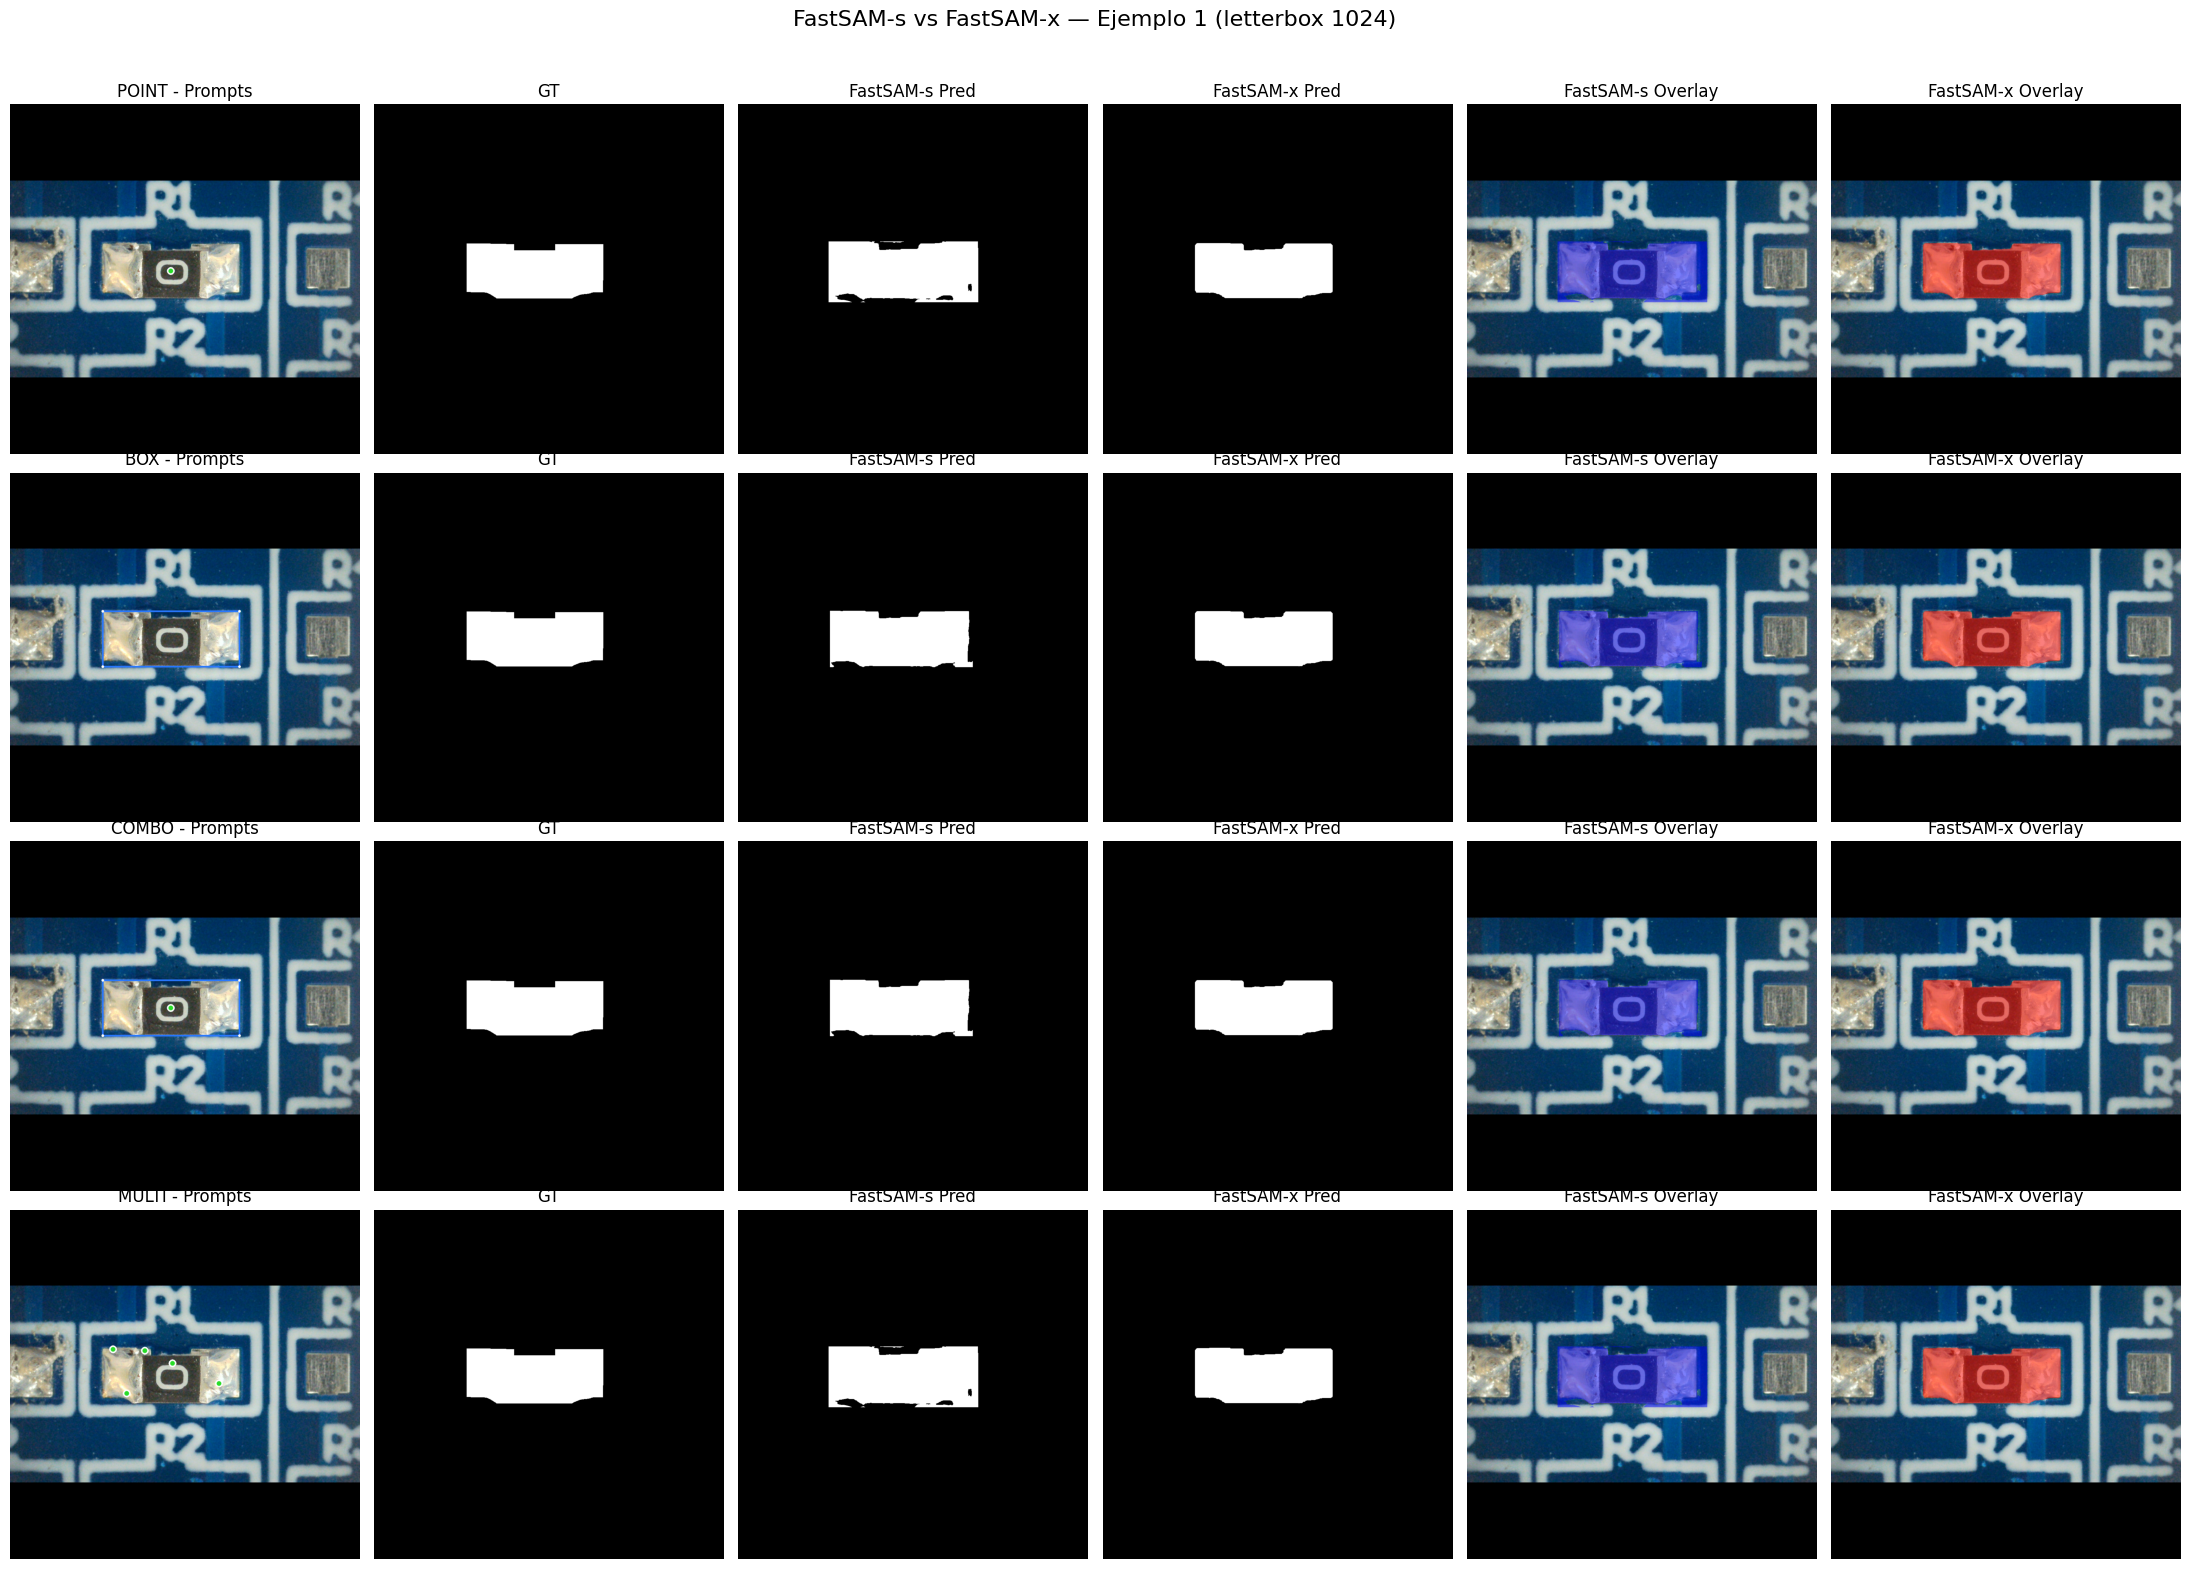


0: 1024x1024 22 objects, 43.2ms
Speed: 4.8ms preprocess, 43.2ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 168.8ms
Speed: 4.3ms preprocess, 168.8ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 23.3ms
Speed: 4.4ms preprocess, 23.3ms inference, 5.6ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 170.2ms
Speed: 4.5ms preprocess, 170.2ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 23.6ms
Speed: 4.1ms preprocess, 23.6ms inference, 5.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 173.1ms
Speed: 4.4ms preprocess, 173.1ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 5.6ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 22 objects, 171.6ms
Speed: 4.6ms preprocess, 171.6ms inf

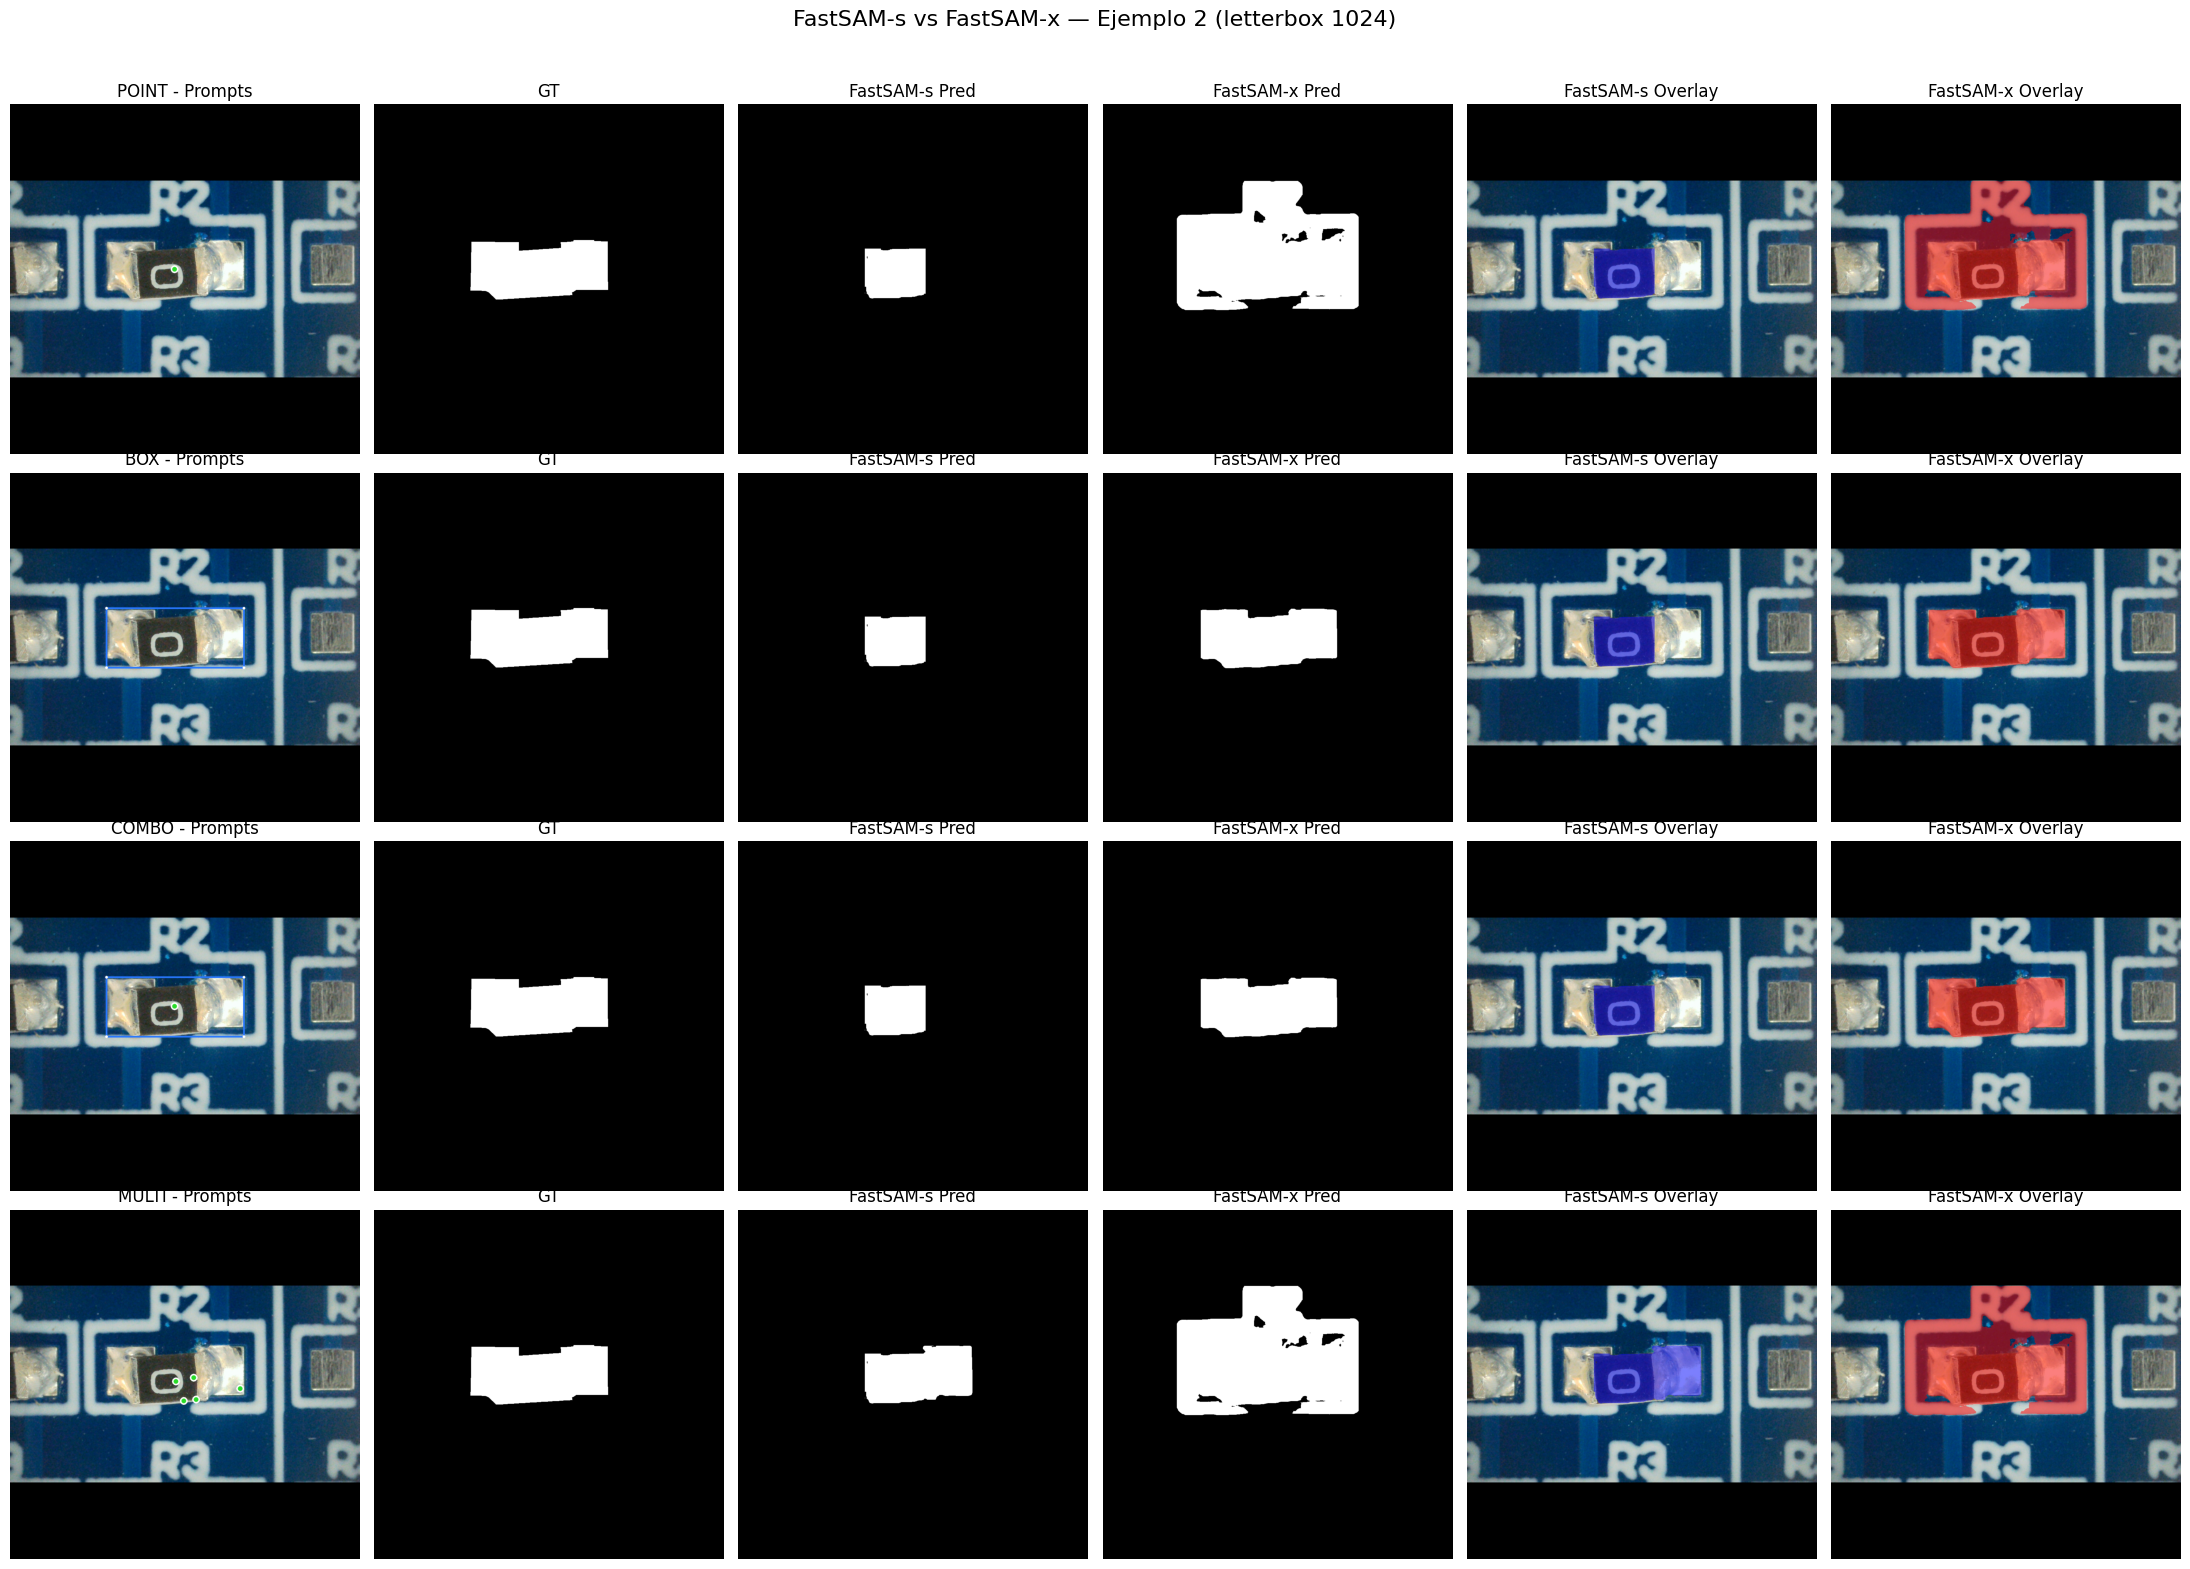


0: 1024x1024 32 objects, 43.3ms
Speed: 5.8ms preprocess, 43.3ms inference, 11.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 24 objects, 174.9ms
Speed: 26.5ms preprocess, 174.9ms inference, 7.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 32 objects, 22.4ms
Speed: 6.1ms preprocess, 22.4ms inference, 7.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 24 objects, 168.5ms
Speed: 6.3ms preprocess, 168.5ms inference, 7.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 32 objects, 28.2ms
Speed: 8.1ms preprocess, 28.2ms inference, 10.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 24 objects, 168.2ms
Speed: 6.3ms preprocess, 168.2ms inference, 7.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 32 objects, 22.5ms
Speed: 5.9ms preprocess, 22.5ms inference, 7.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 24 objects, 172.8ms
Speed: 5.9ms preprocess, 172.8ms 

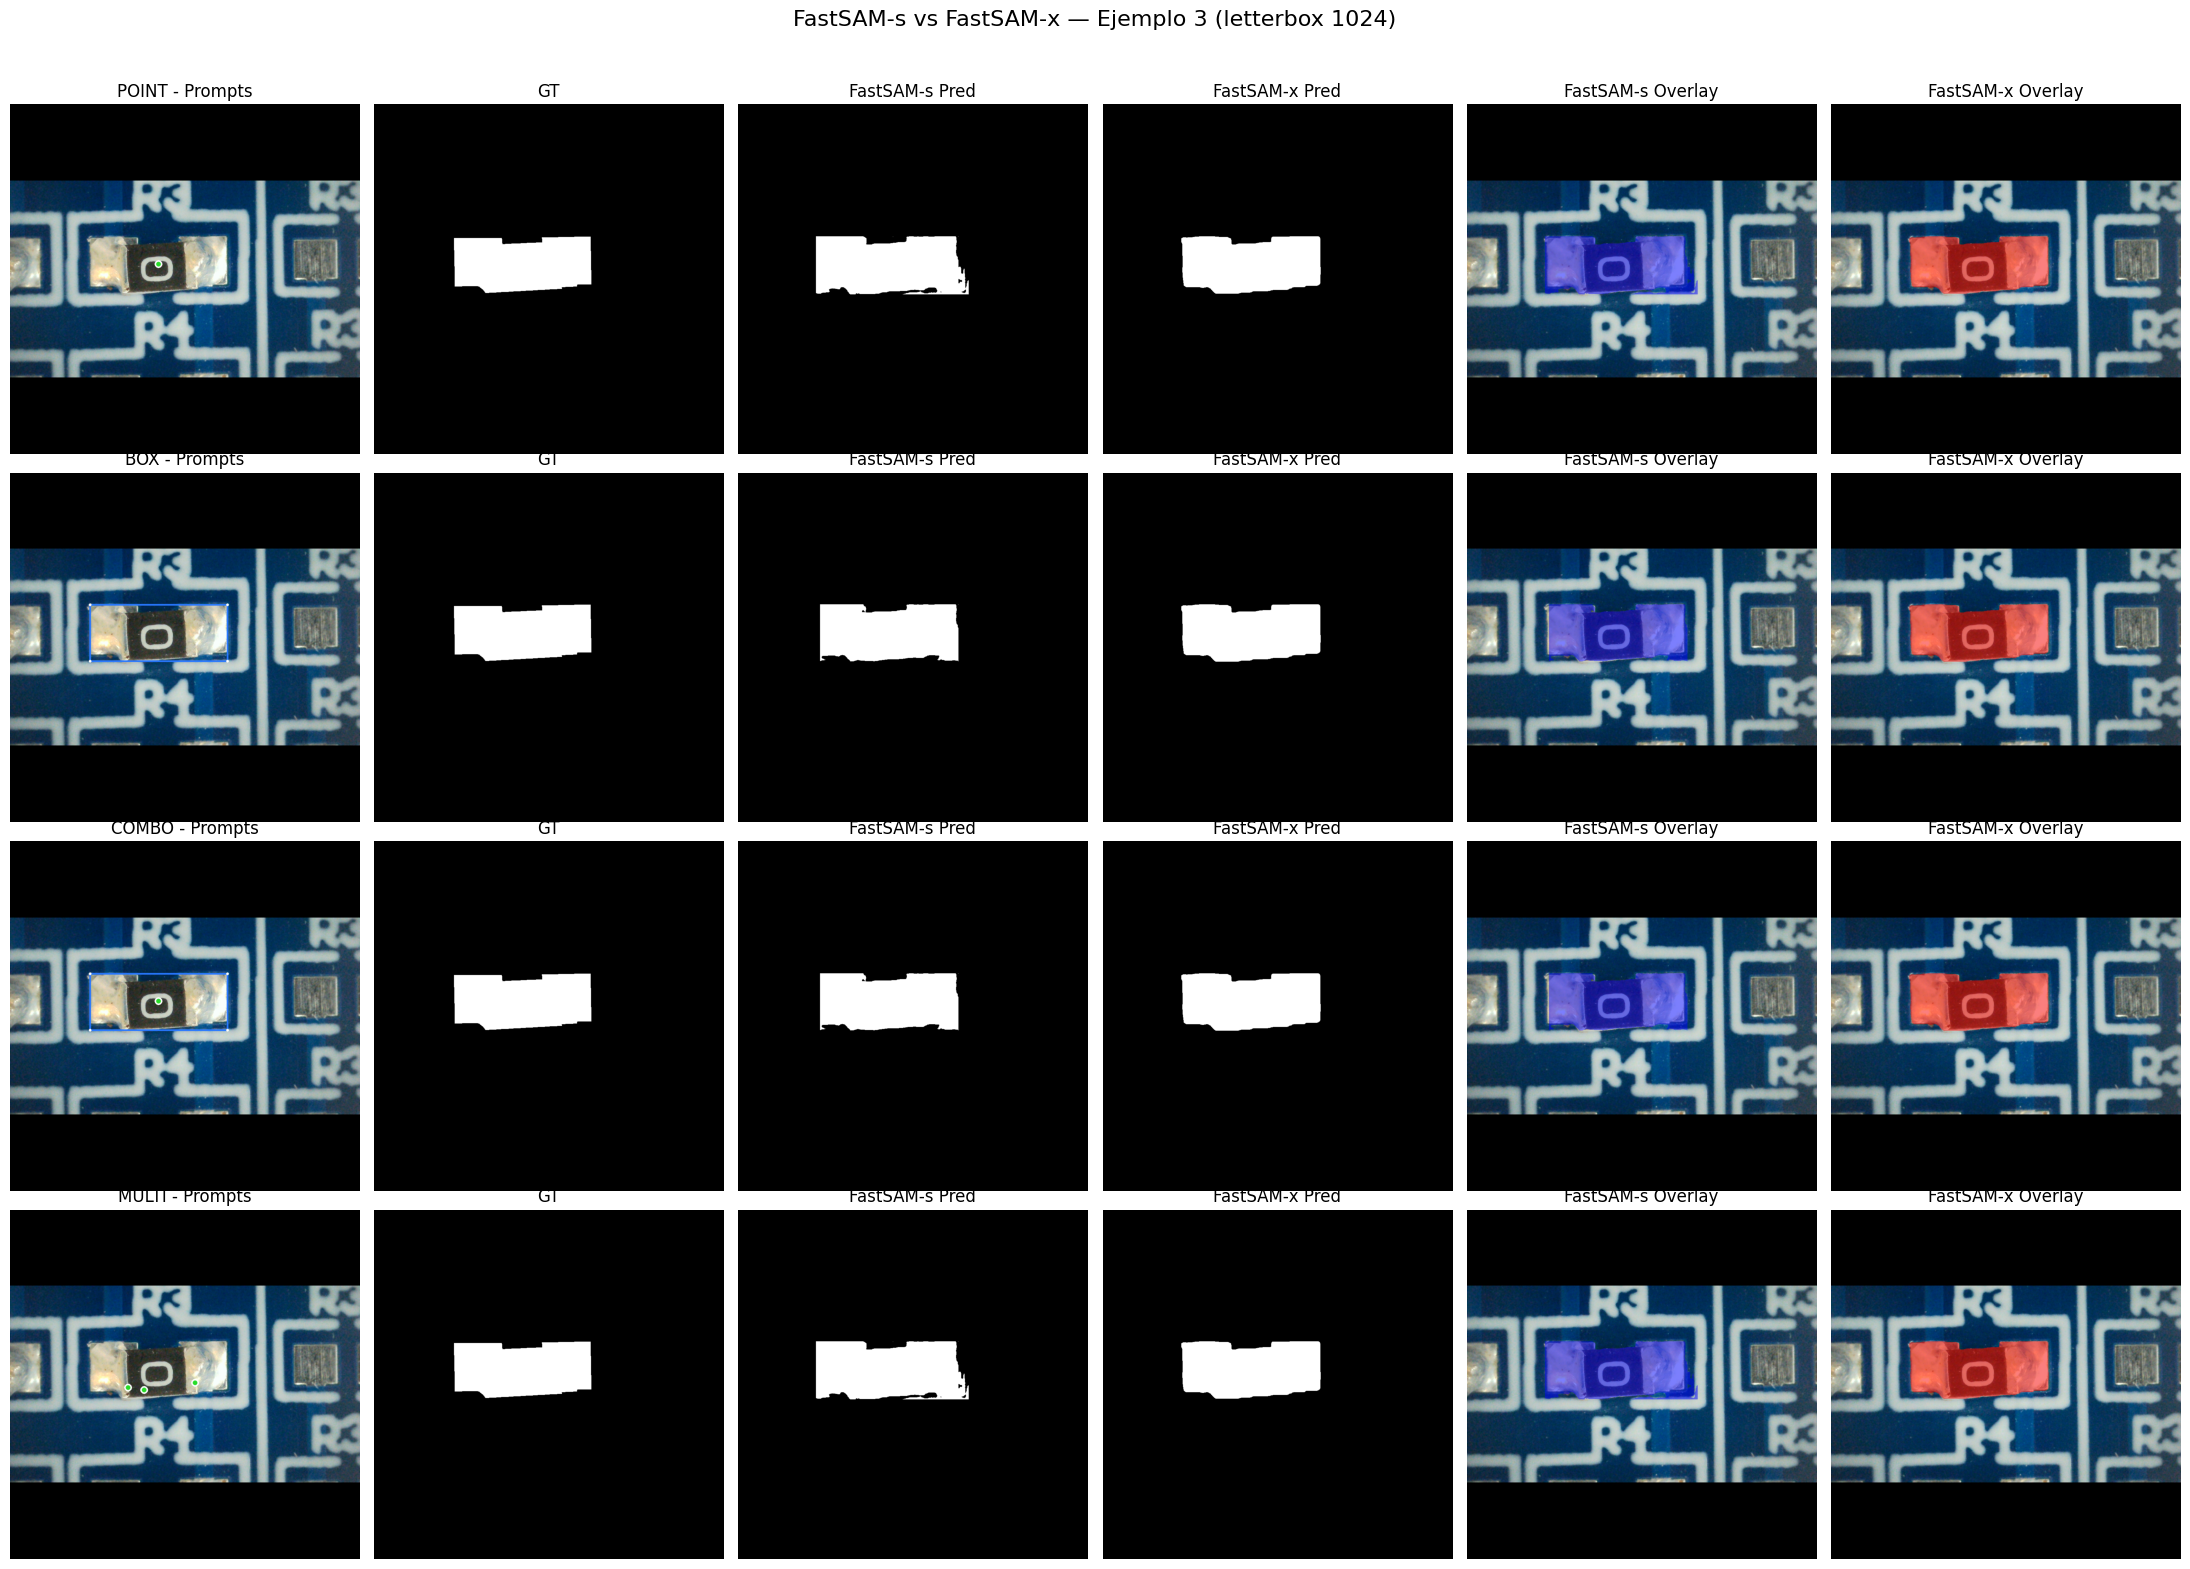


0: 1024x1024 26 objects, 43.2ms
Speed: 5.2ms preprocess, 43.2ms inference, 7.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 19 objects, 171.3ms
Speed: 4.5ms preprocess, 171.3ms inference, 5.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 24.2ms
Speed: 6.2ms preprocess, 24.2ms inference, 6.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 19 objects, 171.8ms
Speed: 5.1ms preprocess, 171.8ms inference, 5.6ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 25.2ms
Speed: 6.7ms preprocess, 25.2ms inference, 7.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 19 objects, 171.1ms
Speed: 4.6ms preprocess, 171.1ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 26 objects, 23.0ms
Speed: 6.2ms preprocess, 23.0ms inference, 6.9ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 19 objects, 171.4ms
Speed: 4.4ms preprocess, 171.4ms inf

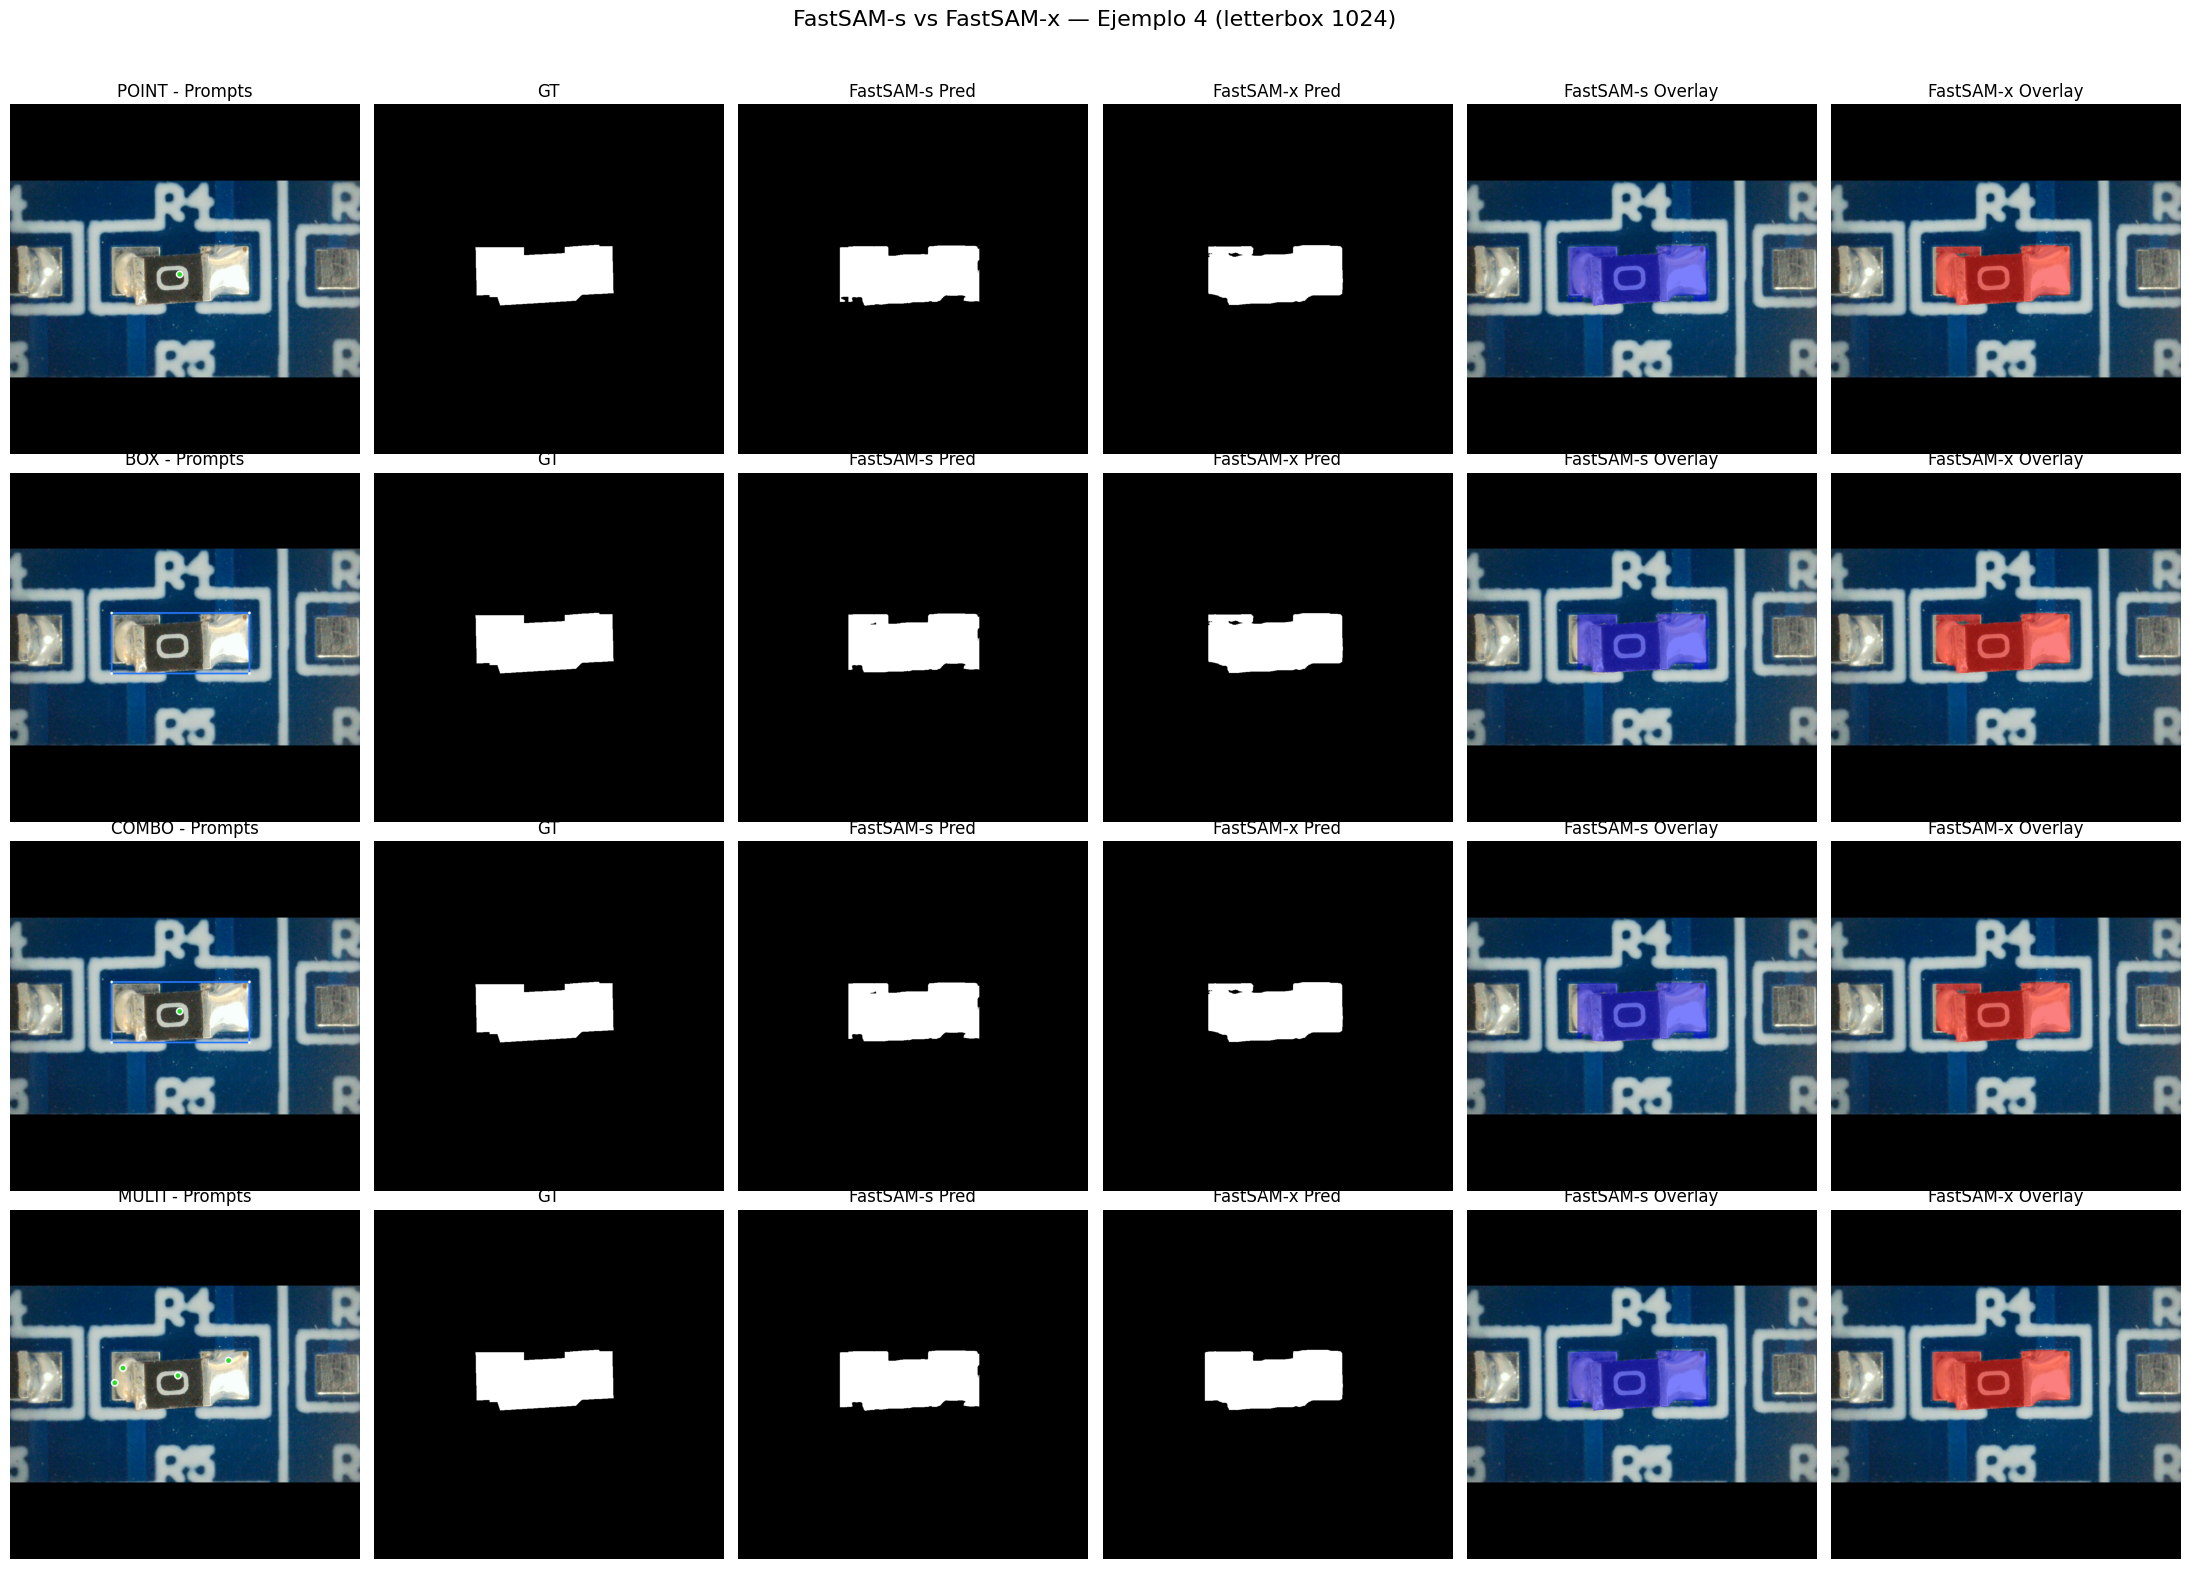

In [ ]:
#  Visualización FastSAM-s vs FastSAM-x
import os, numpy as np, cv2, torch, matplotlib.pyplot as plt
from PIL import Image

#  Config
IM_SIZE   = 1024
MODES     = ("POINT","BOX","COMBO","MULTI")  # filas por modo
N_SAMPLES = 4                                 # cuántas imágenes
START_IDX = 0                                 # índice inicial
CONF      = 0.4                               # conf FastSAM
IOU       = 0.9                               # iou FastSAM
SAVE_DIR  = None
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(SAVE_DIR, exist_ok=True) if SAVE_DIR else None

# Comprobaciones mínimas
assert 'image_paths' in globals() and 'mask_paths' in globals(), "Faltan image_paths y mask_paths."
assert 'predict_fastsam_single' in globals(), "Falta predict_fastsam_single(...)."
assert ('model_fastsam_s' in globals() or ('build_fastsam_safe' in globals() and 'fastsam_s_path' in globals())), \
       "Define model_fastsam_s o build_fastsam_safe(fastsam_s_path)."
assert ('model_fastsam_x' in globals() or ('build_fastsam_safe' in globals() and 'fastsam_x_path' in globals())), \
       "Define model_fastsam_x o build_fastsam_safe(fastsam_x_path)."

#  Modelos
model_s = model_fastsam_s if 'model_fastsam_s' in globals() else build_fastsam_safe(fastsam_s_path)
model_x = model_fastsam_x if 'model_fastsam_x' in globals() else build_fastsam_safe(fastsam_x_path)

#  Helpers
def letterbox_resize(pil_img, size=IM_SIZE, fill=(0,0,0)):
    w, h = pil_img.size
    scale = size / max(w, h)
    new_w, new_h = int(round(w * scale)), int(round(h * scale))
    img_resized = pil_img.resize((new_w, new_h), Image.BILINEAR)
    canvas = Image.new("RGB", (size, size), fill)
    pad_x = (size - new_w) // 2
    pad_y = (size - new_h) // 2
    canvas.paste(img_resized, (pad_x, pad_y))
    return canvas, scale, pad_x, pad_y

def letterbox_mask(mask_pil, scale, pad_x, pad_y, size=IM_SIZE):
    w, h = mask_pil.size
    new_w, new_h = int(round(w * scale)), int(round(h * scale))
    m_resized = mask_pil.resize((new_w, new_h), Image.NEAREST)
    canvas = Image.new("L", (size, size), 0)
    canvas.paste(m_resized, (pad_x, pad_y))
    return (np.array(canvas) > 127).astype(np.uint8)

def compute_center_and_box(gt_mask):
    coords = np.argwhere(gt_mask > 0)
    if coords.size == 0: return None, None
    y0x0 = coords.min(axis=0); y1x1 = coords.max(axis=0)
    y_c, x_c = coords.mean(axis=0).astype(int)
    x0, y0 = int(y0x0[1]), int(y0x0[0]); x1, y1 = int(y1x1[1]), int(y1x1[0])
    return (x_c, y_c), (x0, y0, x1, y1)

def overlay_mask(img_hwc_uint8, mask_bin, alpha=0.45, color=(0,0,255)):
    img = img_hwc_uint8.copy()
    mask = (mask_bin > 0).astype(np.uint8)
    overlay = img.copy()
    overlay[mask == 1] = overlay[mask == 1] * (1 - alpha) + np.array(color) * alpha
    return overlay.astype(np.uint8)

#  Bucle de visualización
rng = np.random.default_rng(0)
indices = range(START_IDX, min(len(image_paths), START_IDX + N_SAMPLES))

for idx in indices:
    pil = Image.open(image_paths[idx]).convert("RGB")
    mask_pil = Image.open(mask_paths[idx]).convert("L")
    gt = (np.array(mask_pil) > 127).astype(np.uint8)
    if gt.sum() == 0:
        continue

    # Letterbox imagen y GT
    canvas_1024, scale, pad_x, pad_y = letterbox_resize(pil, size=IM_SIZE)
    img_1024 = np.array(canvas_1024)
    gt_1024  = letterbox_mask(mask_pil, scale, pad_x, pad_y, size=IM_SIZE)

    # Prompts (coords originales -> 1024 letterbox)
    center, box_xyxy = compute_center_and_box(gt)
    if center is None:
        continue

    def sp(x,y):
        return (int(round(x*scale + pad_x)), int(round(y*scale + pad_y)))
    def sb(b):
        return (int(round(b[0]*scale + pad_x)), int(round(b[1]*scale + pad_y)),
                int(round(b[2]*scale + pad_x)), int(round(b[3]*scale + pad_y)))

    center_1024 = sp(center[0], center[1])
    box_1024    = sb(box_xyxy)

    # Multi-puntos
    x0,y0,x1,y1 = box_xyxy
    points_multi = []
    for _ in range(5):
        x = int(rng.integers(x0, x1 + 1)); y = int(rng.integers(y0, y1 + 1))
        if gt[y, x] > 0: points_multi.append((x, y))
    if not points_multi: points_multi = [center]
    points_multi_1024 = [sp(x,y) for (x,y) in points_multi]

    # Filas a mostrar (un modo por fila)
    rows = []
    if "POINT" in MODES: rows.append(("POINT", [center_1024], None))
    if "BOX"   in MODES: rows.append(("BOX",   None,         box_1024))
    if "COMBO" in MODES: rows.append(("COMBO", [center_1024], box_1024))
    if "MULTI" in MODES: rows.append(("MULTI", points_multi_1024, None))

    # Columnas: Prompts | GT | s Pred | x Pred | s Overlay | x Overlay
    fig, axes = plt.subplots(len(rows), 6, figsize=(22, 4*len(rows)))
    if len(rows) == 1: axes = np.array([axes])
    fig.suptitle(f"FastSAM-s vs FastSAM-x — Ejemplo {idx+1} (letterbox {IM_SIZE})", fontsize=16)

    for r, (mode, pts_1024, box_1024_r) in enumerate(rows):
        # 1) Prompts dibujados
        img_prompts = img_1024.copy()
        if pts_1024:
            for (px,py) in pts_1024:
                cv2.circle(img_prompts, (int(px),int(py)), 9, (255,255,255), 3)
                cv2.circle(img_prompts, (int(px),int(py)), 7, (40,220,40),  -1)
        if box_1024_r is not None:
            x0_,y0_,x1_,y1_ = map(int, box_1024_r)
            cv2.rectangle(img_prompts, (x0_,y0_), (x1_,y1_), (40,120,255), 3)
            for (xx,yy) in [(x0_,y0_),(x1_,y0_),(x0_,y1_),(x1_,y1_)]:
                cv2.circle(img_prompts, (xx,yy), 4, (255,255,255), -1)

        axes[r, 0].imshow(img_prompts); axes[r, 0].set_title(f"{mode} - Prompts"); axes[r, 0].axis("off")
        axes[r, 1].imshow(gt_1024, cmap="gray", vmin=0, vmax=1); axes[r, 1].set_title("GT"); axes[r, 1].axis("off")

        # 2) Construir prompts_abs EXACTO para predict_fastsam_single
        prompts_abs = {}
        if mode in ("POINT","MULTI","COMBO"):
            prompts_abs["points"] = pts_1024 if mode != "POINT" else pts_1024[:1]
        if mode in ("BOX","COMBO"):
            prompts_abs["box_xyxy"] = box_1024_r

        # 3) Predicción con FastSAM-s
        pred_s = predict_fastsam_single(
            model_s, img_1024, mode, prompts_abs,
            device=DEVICE, imgsz=IM_SIZE, conf=CONF, iou=IOU
        )
        if pred_s.dtype != np.uint8:  pred_s = pred_s.astype(np.uint8)
        if pred_s.max() > 1:          pred_s = (pred_s > 127).astype(np.uint8)
        if pred_s.shape != gt_1024.shape:
            pred_s = cv2.resize(pred_s, (IM_SIZE, IM_SIZE), interpolation=cv2.INTER_NEAREST)
            pred_s = (pred_s != 0).astype(np.uint8)

        # 4) Predicción con FastSAM-x
        pred_x = predict_fastsam_single(
            model_x, img_1024, mode, prompts_abs,
            device=DEVICE, imgsz=IM_SIZE, conf=CONF, iou=IOU
        )
        if pred_x.dtype != np.uint8:  pred_x = pred_x.astype(np.uint8)
        if pred_x.max() > 1:          pred_x = (pred_x > 127).astype(np.uint8)
        if pred_x.shape != gt_1024.shape:
            pred_x = cv2.resize(pred_x, (IM_SIZE, IM_SIZE), interpolation=cv2.INTER_NEAREST)
            pred_x = (pred_x != 0).astype(np.uint8)

        # 5) Overlays (s en AZUL, x en ROJO)
        overlay_s = overlay_mask(img_1024, pred_s, alpha=0.5, color=(0,0,255))
        overlay_x = overlay_mask(img_1024, pred_x, alpha=0.5, color=(255,0,0))

        # 6) Plots: s Pred | x Pred | s Overlay | x Overlay
        axes[r, 2].imshow(pred_s, cmap="gray", vmin=0, vmax=1); axes[r, 2].set_title("FastSAM-s Pred"); axes[r, 2].axis("off")
        axes[r, 3].imshow(pred_x, cmap="gray", vmin=0, vmax=1); axes[r, 3].set_title("FastSAM-x Pred"); axes[r, 3].axis("off")
        axes[r, 4].imshow(overlay_s); axes[r, 4].set_title("FastSAM-s Overlay"); axes[r, 4].axis("off")
        axes[r, 5].imshow(overlay_x); axes[r, 5].set_title("FastSAM-x Overlay"); axes[r, 5].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if SAVE_DIR:
        out_path = os.path.join(SAVE_DIR, f"fastsam_s_vs_x_{idx+1}.png")
        plt.savefig(out_path, dpi=160, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

